Another dataset: 
https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [2]:
import pandas as pd
import numpy as np

# Load the raw data


pd.read_csv('spam.csv') # raises unicode decode error

pd.read_csv('spam.csv', encoding='Latin-1') # works 
    

In [3]:
# when encoding is unknown
import chardet 
with open("../Data/sms_spam/spam.csv", 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

print(result['encoding'])
df_raw = pd.read_csv('../Data/sms_spam/spam.csv', encoding=result['encoding'])

Windows-1252


In [4]:
df_raw.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Clean the raw data

In [5]:
df = df_raw[['v1', 'v2']].rename(columns={'v1' : 'label', 'v2' : 'sms'})

In [6]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Explore the clean data

In [7]:
df.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
df.drop_duplicates(subset='sms', inplace=True)

In [9]:
df.describe()

,label,sms
count,5169,5169
unique,2,5169
top,ham,I come n pick Ì_ up... Come out immediately af...
freq,4516,1


In [10]:
df.groupby('label').count().reset_index()

,label,sms
0,ham,4516
1,spam,653


In [11]:
df['len'] = df['sms'].map(lambda x: len(x))

In [12]:
df.groupby('label').agg({'sms': 'count', 'len' : 'mean'}).reset_index()

,label,sms,len
0,ham,4516,70.459256
1,spam,653,137.891271


In [13]:
df_spam = df[df['label'] == 'spam']
df_ham = df[df['label'] == 'ham']
df_spam['sms'].to_csv('../Data/sms_spam/spam')
df_ham['sms'].to_csv('../Data/sms_spam/ham')

# Separate training data and test data

In [14]:
"""
    Train-test split: Do not touch the test data until the time of final evaluation.
        Which stage of the pipeline do we reserve the test data ?
            - after obtaining raw data but before cleaning it 
            - after cleaning but before exploring
            - after exploring but before featurizing/training
"""

from sklearn.model_selection import train_test_split

X = df['sms']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Shape of X is {}".format(X.shape))
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

train_corpus = list(X_train)

Shape of X is (5169,)
Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (1293,) and shape of y_test is (1293,)


# Build a featurizer from training data

In [15]:
"""
    Featurizer: Train the featurizer on train data.
"""
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_corpus)

print("Number of features = {}".format(len(vectorizer.vocabulary_)))
print("Number of omitted words = {}".format(len(vectorizer.stop_words_)))

X_train_text_features = vectorizer.transform(list(X_train))
print("Shape of X_train_text_features is {}".format(X_train_text_features.shape))

Number of features = 5000
Number of omitted words = 2395
Shape of X_train_text_features is (3876, 5000)


# Adding new features

In [16]:
"""
    Adding a new feature
        Do we need to do the train-test split again ?
        >> Yes, if you do not have the new feature in your previous dataframe.
        Otherwise you have to join the corresponding indices.
        
        Do we need to normalize the new feature being added ?
        >> It depends on the model.
            - perhaps decision tree models would not require normalization
            - linear models would require normalization
"""

df['len'] = df['sms'].map(lambda x: len(x))

X = df[['sms', 'len']]
y = df['label']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

train_corpus = list(X_train['sms'])

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_corpus)

from scipy import sparse
def get_features(X):
    X_text_features = vectorizer.transform(list(X['sms']))
    X_len_features = sparse.csr_matrix(X['len']).T
    X_features = sparse.hstack([X_text_features, X_len_features])
    return X_features

X_train_features = get_features(X_train)

# Train a model

In [17]:
"""
    Training a classifier: Train a Logistic Regression classifier
        The classifier uses default setting: L2 regularization is used
        Random state is fixed to 42 in order to be able to repeat the experiment to obtain the same results
"""
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)

model.fit(X_train_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
"""
    Evaluation on training data: This does not mean anything  
        Do not take the evaluate on the same data that you trained on very seriously
"""
from sklearn.metrics import accuracy_score, confusion_matrix

y_train_predicted = model.predict(X_train_features)

print("The fraction of correctly classified samples is {}".format(accuracy_score(y_train, y_train_predicted)))
print("The number of correctly classified samples is {}".format(accuracy_score(y_train, 
                                                                               y_train_predicted, normalize=False)))
pd.DataFrame(confusion_matrix(y_train_predicted, y_train), 
             index=['true ham', 'true spam'], 
             columns=['pred ham', 'pred spam'])

The fraction of correctly classified samples is 0.9760061919504643
The number of correctly classified samples is 3783


,pred ham,pred spam
true ham,3399,83
true spam,10,384


# Cross validation

In [18]:
"""
    Evaluation within training data: k-fold cross validation
        - randomly partition the training data into k parts
        - train on k-1 parts and evaluate on the remaining part
"""

from sklearn.model_selection import cross_val_score

lr_model = LogisticRegression()
cv_scores = cross_val_score(lr_model, X=X_train_features, y=y_train, cv=5, n_jobs=4)
print(cv_scores)


[0.95618557 0.95489691 0.97290323 0.96258065 0.96640827]


In [18]:
"""
The LogisticRegressionCV classifier has inbuilt cross validation
"""
"""
from sklearn.linear_model import LogisticRegressionCV
cv_model = LogisticRegressionCV(cv=5, random_state=42)
cv_model.fit(X_train_features, y_train)
cv_model.scores_
"""

'\nfrom sklearn.linear_model import LogisticRegressionCV\ncv_model = LogisticRegressionCV(cv=5, random_state=42)\ncv_model.fit(X_train_features, y_train)\ncv_model.scores_\n'

# Final evaluation on test data

In [19]:
"""
    Evaluation on test data: This score is important
"""
X_test_features = get_features(X_test)
y_test_predicted = model.predict(X_test_features)

print("The fraction of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted)))
print("The number of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted, normalize=False)))

pd.DataFrame(confusion_matrix(y_test_predicted, y_test), 
             index={'true ham', 'true spam'}, 
             columns={'pred ham', 'pred spam'})

The fraction of correctly classified samples is 0.9737045630317092
The number of correctly classified samples is 1259


,pred spam,pred ham
true ham,1106,33
true spam,1,153


# Serializing and saving the model

In [24]:
from sklearn.externals import joblib
from datetime import date

"""
    Versioning: It is often useful to save the model with a version number.
        One way to do it is to attach current date/time to the filename saved
"""
version = date.today().strftime("%Y_%B_%d")
joblib.dump(vectorizer, 'vectorizer_joblib_{}'.format(version))
joblib.dump(model, 'lr_model_joblib_{}'.format(version))

"""
    How to serialize a function ? 
        Would the following work ?
"""
joblib.dump(get_features, 'featurizer_joblib_{}'.format(version))


['featurizer_joblib_2019_January_06']

In [27]:
reloaded_model = joblib.load('../Models/lr_model_joblib_2018_December_24')
y_test_predicted = reloaded_model.predict(X_test_features)

print("The fraction of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted)))
print("The number of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted, normalize=False)))

pd.DataFrame(confusion_matrix(y_test_predicted, y_test), 
             index={'true ham', 'true spam'}, 
             columns={'pred ham', 'pred spam'})

The fraction of correctly classified samples is 0.9737045630317092
The number of correctly classified samples is 1259


,pred ham,pred spam
true spam,1106,33
true ham,1,153


In [31]:
reloaded_featurizer = joblib.load('../Models/featurizer_joblib_2018_December_24')
reloaded_vectorizer = joblib.load('../Models/vectorizer_joblib_2018_December_24')
reloaded_model = joblib.load('../Models/lr_model_joblib_2018_December_24')

text = "I am not spam."

X_text = pd.DataFrame({'sms': [text], 'len': [len(text)]})
reloaded_model.predict(reloaded_featurizer(X_text))

array(['ham'], dtype=object)

# Top 20 features

In [35]:
pd.Series (
    reloaded_model.coef_.T.ravel(),
    index=vectorizer.get_feature_names() + ['LEN']
).sort_values(ascending=False)[:20]

call       3.946334
txt        3.356191
text       2.795574
free       2.792163
mobile     2.465806
claim      2.306686
reply      2.279622
service    2.265740
stop       2.201091
150p       2.188507
www        2.084460
uk         2.027968
your       1.877783
50         1.834914
now        1.810069
win        1.770189
won        1.746124
prize      1.739970
or         1.666726
message    1.654107
dtype: float64

# References
- How to handle class imbalance?
https://elitedatascience.com/imbalanced-classes

# Training and evaluating multiple models

https://www.kaggle.com/muzzzdy/sms-spam-detection-with-various-classifiers


In [23]:
"""
    Observing cross validation scores of several models    
"""
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

from collections import defaultdict

models = defaultdict()

logistic_regression = LogisticRegression()
models['logistic_regression'] = logistic_regression

decision_tree = DecisionTreeClassifier()
models['decision_tree'] = decision_tree

random_forest = RandomForestClassifier()
models['random_forest'] = random_forest


for key, model in models.items():
    cv_score = cross_val_score(model, X_train_features, y_train, cv=5, n_jobs=4).mean()
    print(cv_score)
    models[key] = {'model': model, 'cv_score': cv_score}
    
df_scores = pd.DataFrame.from_dict(models, orient='index', columns=['cv_score'])    

/home/raghav/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9625949227856792
0.9563970468562157
0.9687848164790338


# Ensemble: Voting classifier

In [24]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=[('lr', logistic_regression), 
                                                 ('dt', decision_tree), 
                                                 ('rf', random_forest)])

voting_classifier.fit(X_train_features, y_train)

y_test_predicted = voting_classifier.predict(X_test_features)

print("The fraction of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted)))
print("The number of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted, normalize=False)))

pd.DataFrame(confusion_matrix(y_test_predicted, y_test), 
             index={'true ham', 'true spam'}, 
             columns={'pred ham', 'pred spam'})

The fraction of correctly classified samples is 0.9760247486465584
The number of correctly classified samples is 1262


/home/raghav/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,pred ham,pred spam
true spam,1107,31
true ham,0,155


# Logistic Regression: Hyperparameter Tuning via Grid Search

In [25]:
"""
    Training and evaluating a Logistic Regression model on combination of hyperparameters
"""
from sklearn.model_selection import GridSearchCV
hyper_parameters = {
    'penalty' : ['l1', 'l2'],
    'class_weight' : [None, 'balanced'],
    'C': [0.25, 0.5, 1]
}

logistic_regression = LogisticRegression()

grid_search_classifier = GridSearchCV(logistic_regression, hyper_parameters, cv=3)
nb_detector = grid_search_classifier.fit(X_train_features, y_train)
nb_detector.grid_scores_

/home/raghav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89680, std: 0.00743, params: {'C': 0.25, 'class_weight': None, 'penalty': 'l1'},
 mean: 0.91022, std: 0.00563, params: {'C': 0.25, 'class_weight': None, 'penalty': 'l2'},
 mean: 0.89319, std: 0.00213, params: {'C': 0.25, 'class_weight': 'balanced', 'penalty': 'l1'},
 mean: 0.92337, std: 0.00679, params: {'C': 0.25, 'class_weight': 'balanced', 'penalty': 'l2'},
 mean: 0.93885, std: 0.00578, params: {'C': 0.5, 'class_weight': None, 'penalty': 'l1'},
 mean: 0.93808, std: 0.00412, params: {'C': 0.5, 'class_weight': None, 'penalty': 'l2'},
 mean: 0.93473, std: 0.00488, params: {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1'},
 mean: 0.95253, std: 0.00476, params: {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2'},
 mean: 0.95691, std: 0.00323, params: {'C': 1, 'class_weight': None, 'penalty': 'l1'},
 mean: 0.95743, std: 0.00577, params: {'C': 1, 'class_weight': None, 'penalty': 'l2'},
 mean: 0.95356, std: 0.00505, params: {'C': 1, 'class_weight': 'balanced', 'penalty': 

# Decision Tree: hyperparameter tuning

In [26]:
"""
    Training a decision tree of various depth and printing cross validation scores
"""
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

d_max = 3

cv_scores = []
for d in range(1, d_max+1):
    model = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, X=X_train_features, y=y_train, cv=5, n_jobs=4)
    cv_scores.append((scores.mean(), scores.std()))
    
for mean, std in cv_scores:
    print("mean = {} std = {}".format(mean, std))

mean = 0.8795153840006392 std = 0.0005332502619686193
mean = 0.9187342368238107 std = 0.004089638434043284
mean = 0.9354971251403917 std = 0.004593070527927408


# Pipeline

In [32]:
import pandas as pd
import numpy as np
import chardet 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from datetime import date

path_to_data = "../Data/sms_spam/spam.csv"
# when encoding is unknown
with open(path_to_data, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

print(result['encoding'])
df_raw = pd.read_csv(
    path_to_data, encoding=result['encoding'])

df = df_raw[['v1', 'v2']].rename(columns={'v1' : 'label', 'v2' : 'sms'})
df.drop_duplicates(subset='sms', inplace=True)




X = df['sms']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Shape of X is {}".format(X.shape))
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('classifier', LogisticRegression())])


print("The cross validation scores are: {}".format(cross_val_score(pipeline, X=X_train, y=y_train, cv=5)))

pipeline.fit(X_train, y_train)

version = date.today().strftime("%Y_%B_%d")
model_path = '../Models/Spam/model.joblib_{}'.format(version)
joblib.dump(pipeline, model_path)

reloaded_pipeline = joblib.load(model_path)


y_test_predicted = reloaded_pipeline.predict(X_test)

print("The fraction of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted)))
print("The number of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted, normalize=False)))


pd.DataFrame(confusion_matrix(y_test, y_test_predicted), # y_test comes first
             index={'true ham', 'true spam'}, 
             columns={'pred ham', 'pred spam'})

Windows-1252
Shape of X is (5169,)
Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (1293,) and shape of y_test is (1293,)
The cross validation scores are: [0.96134021 0.95876289 0.96645161 0.95612903 0.95994832]
The fraction of correctly classified samples is 0.9644238205723125
The number of correctly classified samples is 1247


,pred spam,pred ham
true ham,1104,3
true spam,43,143


# Plotting precision-recall curve and roc/auc

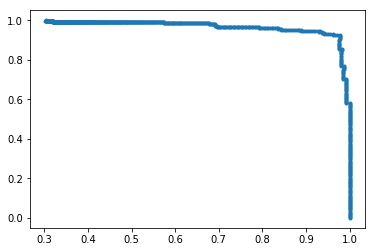

In [51]:
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

def get_binary_label(label):
    if label == 'spam':
        return 1
    else:
        return 0
    
y_true = [get_binary_label(label) for label in list(y_test)] 
y_scores = np.array([probas[1] for probas in list(pipeline.predict_proba(X_test))])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

pyplot.plot(precision, recall, marker='.')
# show the plot
pyplot.show()

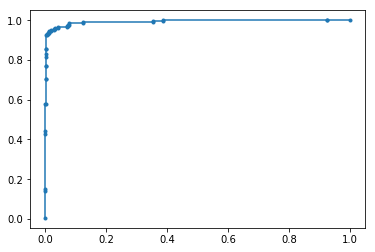

In [52]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [53]:
# calculate AUC
auc = roc_auc_score(y_true, y_scores)
print('AUC: %.3f' % auc)

AUC: 0.993


# Create a flask-API 
# Creating a docker image of the flask-app
# Deploying the docker image to AWS

In [14]:
import os
import os 

filenames = []
for root, dirs, files in os.walk("../Models/Spam"):   
    for filename in files: 
        print(filename) 
        filenames.append(filename)
filenames.sort(key=lambda x: x.split('joblib')[-1], reverse=True)

filenames[0]

model.joblib_2018_December_26
model.joblib_2018_December_29


'model.joblib_2018_December_29'